In [1]:
import numpy.random as rnd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from experiment import perform_experiment

In [2]:
rnd.seed(0)

### experiment 1: constants

(3,)


/home/olga/Projects/stochastiki/mc/experiment.py:222: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


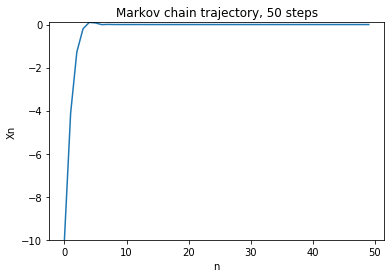

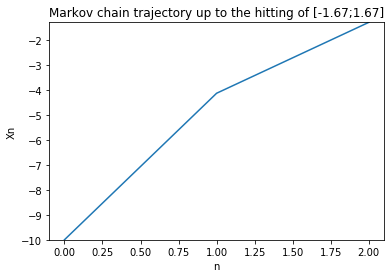

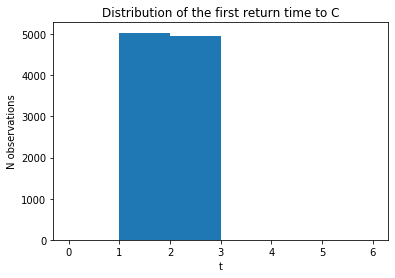

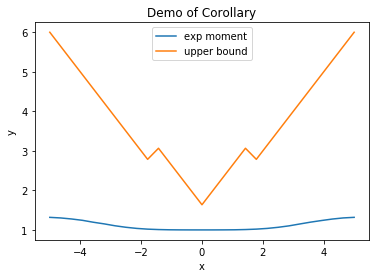

In [3]:
def get_alpha(n):
    return (n+1)**(-1)

def get_sigma(n):
    return 2**(-n)


n_steps = 50
n_samples = 10**4

c = 1.67
eps = sigma = 1/2
assert c >= max(1, 2*(2*sigma / ((2*np.pi)**0.5)) / (1-eps))

x_0 = -10
x = np.linspace(-5, 5, 29)

perform_experiment(
    name="constants",
    gen_alpha=get_alpha,
    gen_sigma=get_sigma,
    starting_point_single=x_0,
    starting_point_multiple=x,
    c=c,
    eps=eps,
    sigma=sigma,
    n_steps=n_steps,
    n_samples=n_samples
)

### experiment 2: random variances

(2,)


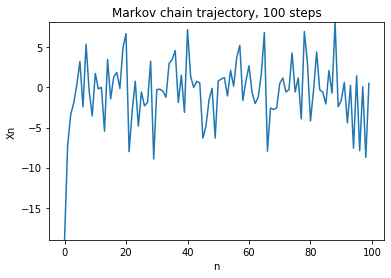

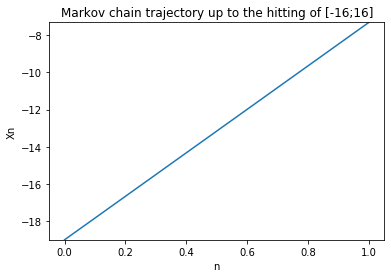

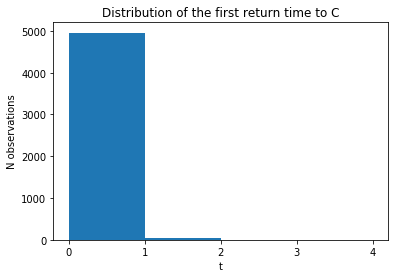

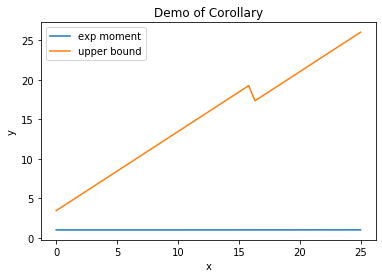

In [4]:
def get_alpha(n):
    return (n+2)**(-1)

def get_sigma(n):
    return rnd.choice([5, 3, 1], size=[1])

n_steps = 100
n_samples = 5 * 10**3

c = 16
eps = 1/2
sigma = 5
assert c >= max(1, 2*(2*sigma / ((2*np.pi)**0.5)) / (1-eps))

x_0 = -19
x = np.linspace(0, 25, 50)

perform_experiment(
    name="rand_var",
    gen_alpha=get_alpha,
    gen_sigma=get_sigma,
    starting_point_single=x_0,
    starting_point_multiple=x,
    c=c,
    eps=eps,
    sigma=sigma,
    n_steps=n_steps,
    n_samples=n_samples,
    n_ticks=5
)

### experiment 3: random coefficient

douc 2.1.7

(2,)


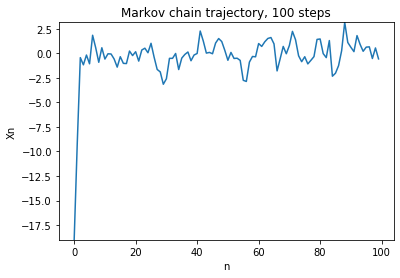

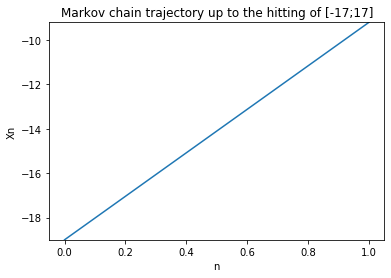

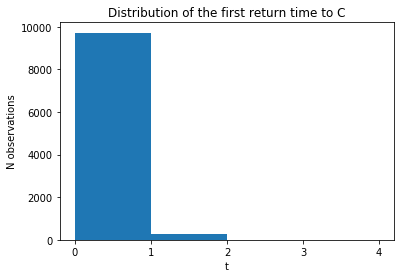

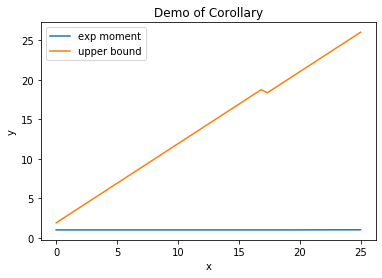

In [5]:
step = 10**(-1)

def get_alpha(n):
    return rnd.uniform(low=step, high=1-step, size=[1])

def get_sigma(n):
    return 1+0.03*n/(n+1)

n_steps = 10**2
n_samples = 10**4

c = 17
eps = 1 - step
sigma = 1.03
assert c >= max(1, 2*(2*sigma / ((2*np.pi)**0.5)) / (1-eps))

x_0 = -19
x = np.linspace(0, 25, 50)

perform_experiment(
    name="rand_alpha",
    gen_alpha=get_alpha,
    gen_sigma=get_sigma,
    starting_point_single=x_0,
    starting_point_multiple=x,
    c=c,
    eps=eps,
    sigma=sigma,
    n_steps=n_steps,
    n_samples=n_samples,
    n_ticks=5
)